In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
from math import comb
import math
import os
import json
from pathlib import Path
import cProfile

from stringart.preprocessing.image import BaseImage, create_mask, apply_mask, create_anchors
from stringart.preprocessing.importancemaps import open_importance_maps, outline_importance_map, combine_importance_maps, background_importance_map
from stringart.core.stringimage import StringArtImage
from stringart.preprocessing.linedicts import make_line_dict
from stringart.algorithm.execute import create_string_art
from stringart.utils.io import save_string_art, load_string_art, save_instructions
from stringart.algorithm.costmethod import CostMethod
from stringart.algorithm.lines import draw_line

from stringart.algorithm.gpu.exec_gpu import create_string_art_gpu


In [2]:
THREAD_WIDTH = 0.2
PLATE_DIAMETER = 300
NUM_ANCHORS = 300
LINE_WIDTH = 1

In [3]:
IMG_SIZE = int(PLATE_DIAMETER/THREAD_WIDTH)
IMG_SIZE = 1400
print(f"Image Size: {IMG_SIZE}")

Image Size: 1400


In [4]:
def display_images(image_list):
    if not isinstance(image_list, list):
        image_list = [image_list]  # Make sure image_list is a list for consistent processing

    num_images = len(image_list)
    
    # Adjust for single image case
    if num_images == 1:
        fig, axes = plt.subplots(figsize=(10, 10))
        axes = [axes]  # Make axes a list for consistent processing
    else:
        fig, axes = plt.subplots(1, num_images, figsize=(num_images * 8, 8))
    
    for ax, img in zip(axes, image_list):
        ax.imshow(img.T, cmap="gray_r")
        ax.axis('off')  # Turn off axis numbers and ticks
    
    plt.tight_layout()
    plt.show()

In [5]:
def display_importance(importance_map):
    plt.figure(figsize=(5,5))
    plt.imshow(importance_map.T, cmap='RdBu_r')
    plt.colorbar()
    plt.show()

In [6]:
base_img = BaseImage(path="./data/tom.jpg", resize_to=IMG_SIZE)
# base_img.img = 1-base_img.img
mask = create_mask(base_img.img)
base_img.img = apply_mask(base_img.img, mask)
anchors = create_anchors(img=base_img.img, num_anchors=NUM_ANCHORS)

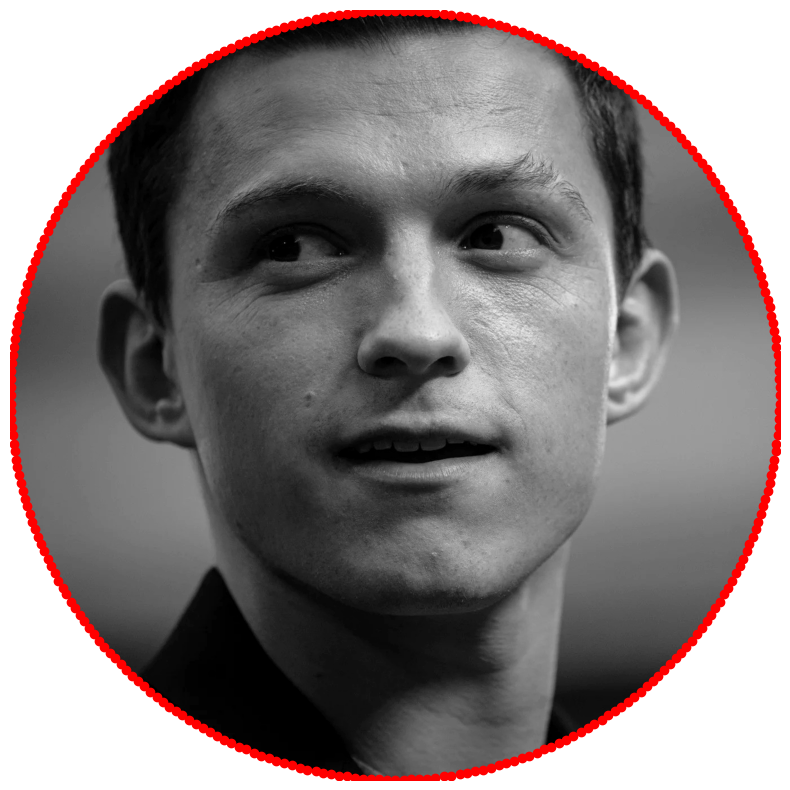

In [7]:
plt.figure(figsize=(10, 10))  
plt.imshow(base_img.img.T, cmap='gray_r')
anchors_x = [anchor.coordinates[0] for anchor in anchors]
anchors_y = [anchor.coordinates[1] for anchor in anchors]
plt.scatter(anchors_x, anchors_y, color='red')
plt.axis('off')
plt.show()  

In [8]:
string_art_img = StringArtImage(base_image=base_img, anchors=anchors, line_darkness=0.2, mask=mask)

In [9]:
importance_maps = open_importance_maps(folder_path="./data/importance_maps/tom/", string_art_img_shape=string_art_img.img.shape)
# TODO: make a way to increase contrast
# TODO: make the bottom cap brightness 0.2

In [10]:
outline_importance_maps = []
for map in importance_maps:
    outline_map = outline_importance_map(importance_map=map, edge_thickness=3)
    outline_importance_maps.append(outline_map)

In [11]:
background_map = background_importance_map(importance_map=importance_maps[2], cutoff=0.1)

In [12]:
for map in importance_maps:
    map.img *= 2
for map in outline_importance_maps:
    map.img *= 4

background_map.img *= (-1)

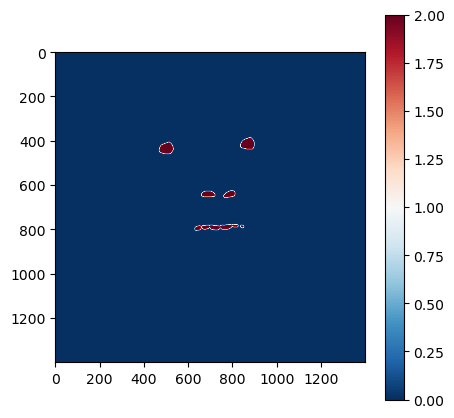

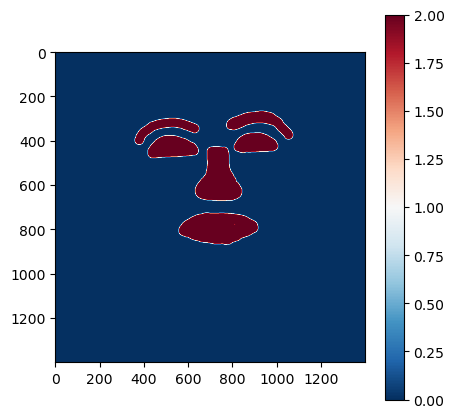

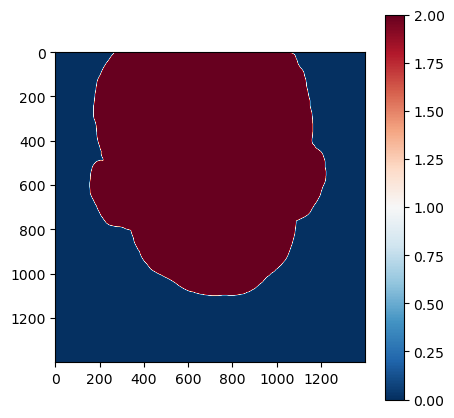

In [13]:
for map in importance_maps:
    display_importance(importance_map=map.img)

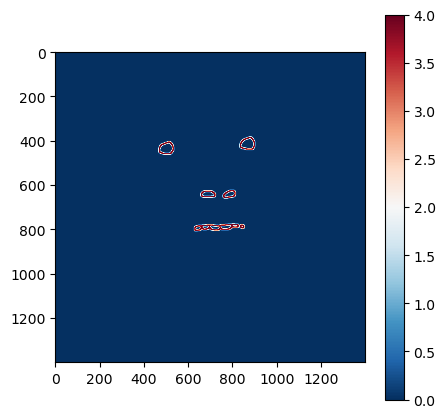

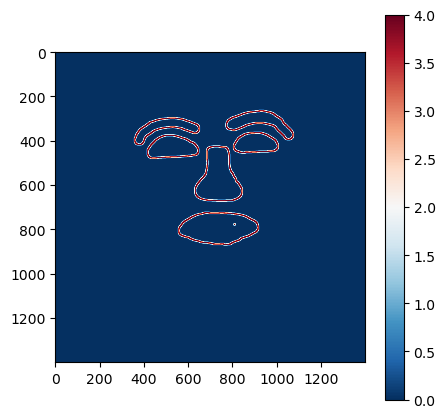

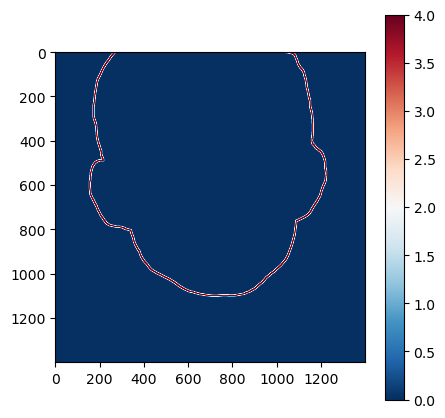

In [14]:
for map in outline_importance_maps:
    display_importance(map.img)

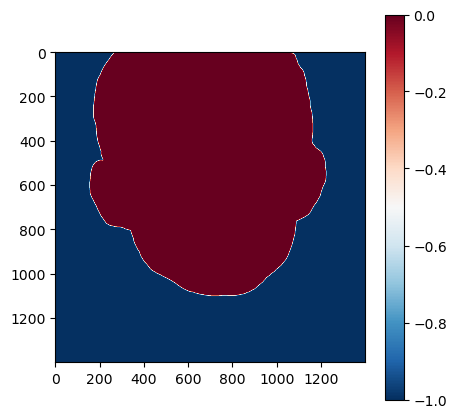

In [15]:
display_importance(background_map.img)

In [16]:
all_importance_maps = importance_maps + outline_importance_maps + [background_map]
main_importance_map = combine_importance_maps(all_importance_maps)
main_importance_map.apply_gaussian_blur(35)
main_importance_map.apply_dynamic_sigmoid(exponent=1, std_exponent=1)

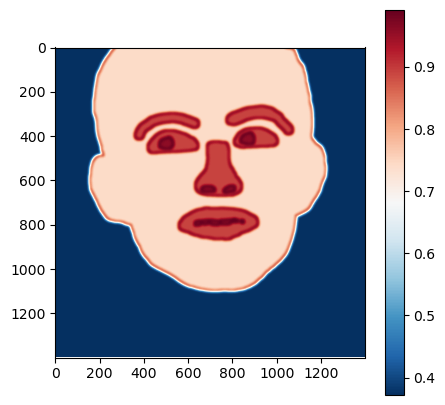

In [17]:
display_importance(main_importance_map.img)

In [18]:
line_pixel_dict, line_darkness_dict = make_line_dict(
    data_folder="./data",
    string_art_img=string_art_img,
    closest_neighbors=10,
)

Opening existing line dictionary


In [19]:
final_img = create_string_art(
    first_anchor=0,
    base_img=base_img,
    string_art_img=string_art_img,
    line_pixel_dict=line_pixel_dict,
    line_darkness_dict=line_darkness_dict,
    iterations=10000,
    cost_method=CostMethod.MEAN,
    max_darkness=1,
    importance_map=main_importance_map,
    use_prev_anchor=True,
    random_neighbor=False,
    profiling=False
)

Building line arrays: 41850it [00:02, 16520.15it/s]
Building initial line costs: 41850it [00:00, 131542.10it/s]
Flattening line pixels: 41850it [00:00, 154271.88it/s]
Flattening line weights: 41850it [00:00, 180870.37it/s]
Mapping anchors to lines: 100%|██████████| 41850/41850 [00:00<00:00, 2331221.08it/s]


Building pixel-to-line mapping (CSR)…


Creating string art for ./data/tom.jpg: 100%|██████████| 10000/10000 [00:03<00:00, 2747.25it/s]


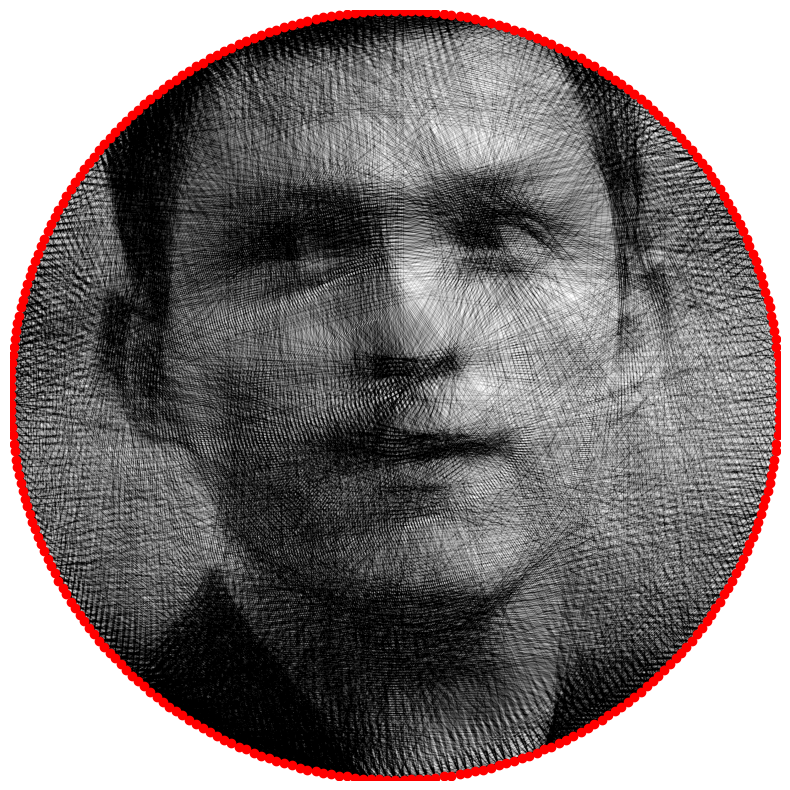

In [20]:
plt.figure(figsize=(10, 10))  
plt.imshow(final_img.img.T, cmap='gray_r', vmin=0, vmax=1)
anchors_x = [anchor.coordinates[0] for anchor in anchors]
anchors_y = [anchor.coordinates[1] for anchor in anchors]
plt.scatter(anchors_x, anchors_y, color='red')
plt.axis('off')
plt.show()

In [21]:
print(final_img.string_path[-100 : -1])

[(110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98), (97, 109), (110, 98)

In [22]:
print(anchors[1].coordinates)

(1399, 715)


In [23]:
line_lengths = []
for iter in tqdm(range(len(final_img.string_path))):
    start_coords = anchors[final_img.string_path[iter][0]].coordinates
    end_coords = anchors[final_img.string_path[iter][1]].coordinates
    line = draw_line(start_coords, end_coords, multiplier=1, mask=string_art_img.mask)
    line_lengths.append((len(line[0]), iter))
    

  0%|          | 0/10000 [00:00<?, ?it/s]

In [24]:
print(line_lengths)

[(2378, 0), (258, 1), (500, 2), (312, 3), (368, 4), (556, 5), (305, 6), (378, 7), (426, 8), (472, 9), (632, 10), (686, 11), (518, 12), (608, 13), (464, 14), (408, 15), (350, 16), (322, 17), (696, 18), (640, 19), (802, 20), (272, 21), (320, 22), (746, 23), (880, 24), (332, 25), (540, 26), (522, 27), (574, 28), (690, 29), (826, 30), (886, 31), (752, 32), (648, 33), (600, 34), (492, 35), (444, 36), (396, 37), (812, 38), (636, 39), (688, 40), (924, 41), (740, 42), (468, 43), (744, 44), (914, 45), (408, 46), (864, 47), (652, 48), (702, 49), (778, 50), (846, 51), (972, 52), (466, 53), (810, 54), (562, 55), (250, 56), (930, 57), (554, 58), (694, 59), (790, 60), (409, 61), (319, 62), (922, 63), (1022, 64), (770, 65), (282, 66), (864, 67), (970, 68), (365, 69), (656, 70), (582, 71), (370, 72), (832, 73), (610, 74), (740, 75), (894, 76), (826, 77), (552, 78), (508, 79), (458, 80), (860, 81), (964, 82), (263, 83), (946, 84), (1098, 85), (970, 86), (1018, 87), (2450, 88), (2426, 89), (836, 90), (7

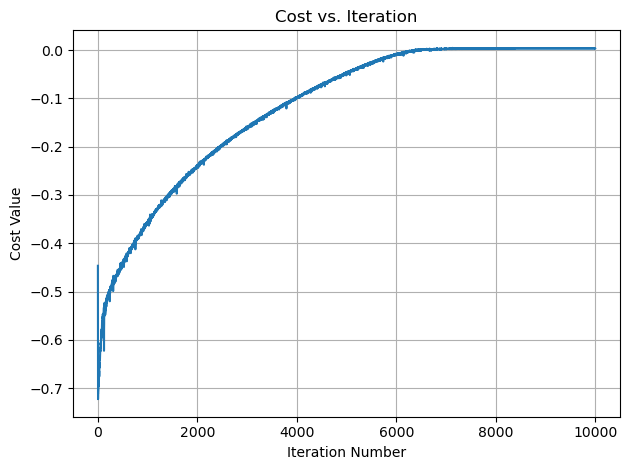

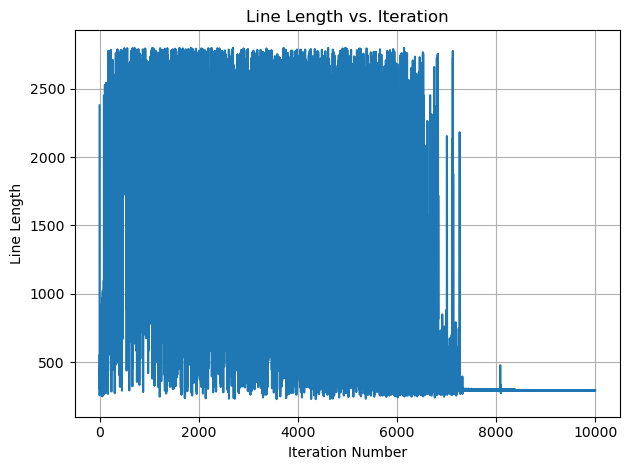

In [26]:
# Unzip cost_list into two sequences
costs, iterations = zip(*final_img.cost_list)
lengths, _ = zip(*line_lengths)

# If your cost_list isn’t sorted by iteration, you can sort it:
# iterations, costs = zip(*sorted(cost_list, key=lambda x: x[1]))

# Create the plot
plt.figure()                # new figure
plt.plot(iterations, costs) # x=iteration, y=cost
plt.xlabel("Iteration Number")
plt.ylabel("Cost Value")
plt.title("Cost vs. Iteration")
plt.grid(True)              # optional grid for readability
plt.tight_layout()          # nice padding
plt.show()

plt.figure()                # new figure
plt.plot(iterations, lengths)
plt.xlabel("Iteration Number")
plt.ylabel("Line Length")
plt.title("Line Length vs. Iteration")
plt.grid(True)              # optional grid for readability
plt.tight_layout()          # nice padding
plt.show()

In [47]:
print(final_img.cost_list[-10])

(0.004020108801709613, 14990)


In [ ]:
save_string_art(string_art_img=final_img, directory="./outputs/scioly")

In [ ]:
final_img: StringArtImage = load_string_art("./outputs/MSE")

In [ ]:
save_instructions(string_path=final_img.string_path, num_anchors=NUM_ANCHORS, path="./outputs/scioly/file.txt")

0,L,299,R,10,L,9,R,291,L,290,R,10,L,11,R,293,L,292,R,9,L,8,R,46,L,45,R,7,L,8,R,287,L,288,R,8,L,7,R,44,L,45,R,8,L,7,R,43,L,44,R,6,L,5,R,16,L,15,R,4,L,5,R,42,L,41,R,6,L,7,R,284,L,283,R,8,L,9,R,47,L,48,R,8,L,9,R,286,L,285,R,10,L,11,R,289,L,290,R,8,L,7,R,279,L,280,R,7,L,8,R,47,L,46,R,9,L,8,R,43,L,42,R,6,L,5,R,43,L,42,R,212,L,211,R,41,L,40,R,211,L,210,R,37,L,36,R,107,L,108,R,36,L,35,R,107,L,106,R,35,L,36,R,109,L,110,R,135,L,134,R,145,L,144,R,128,L,127,R,140,L,139,R,128,L,127,R,145,L,146,R,132,L,133,R,146,L,145,R,128,L,129,R,140,L,141,R,127,L,126,R,140,L,139,R,128,L,127,R,146,L,147,R,131,L,132,R,148,L,147,R,128,L,129,R,144,L,145,R,133,L,132,R,144,L,145,R,126,L,125,R,140,L,141,R,125,L,126,R,146,L,145,R,129,L,130,R,94,L,95,R,130,L,129,R,92,L,93,R,129,L,130,R,97,L,96,R,130,L,129,R,147,L,148,R,133,L,134,R,145,L,144,R,298,L,297,R,143,L,144,R,127,L,128,R,89,L,88,R,128,L,129,R,96,L,97,R,129,L,130,R,143,L,144,R,299,L,298,R,143,L,142,R,296,L,297,R,144,L,145,R,299,L,0,R,147,L,146,R,125,L,126,R,138,L,1